
Initial portfolio value = $ 789230.94


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 789230.94, value end = $ 749509.71
  Strategy "Equally Weighted Portfolio", value begin = $ 782156.71, value end = $ 669639.02
  Strategy "Mininum Variance Portfolio", value begin = $ 781378.07, value end = $ 666783.23
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 781378.15, value end = $ 681744.86
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 782130.00, value end = $ 674057.48
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 778857.97, value end = $ 562230.34
  Strategy "Robust Optimization Portfolio", value begin = $ 782104.80, value end = $ 679156.32

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 754361.26, value end = $ 752687.89
  Strategy "Equally Weighted Portfolio", value begin = $ 659646.52, value end = $ 726703.94
  Strategy "Mininum

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 380341.72, value end = $ 430650.60
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 675563.00, value end = $ 755261.03
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 341049.10, value end = $ 421498.80
  Strategy "Robust Optimization Portfolio", value begin = $ 666551.33, value end = $ 745278.15


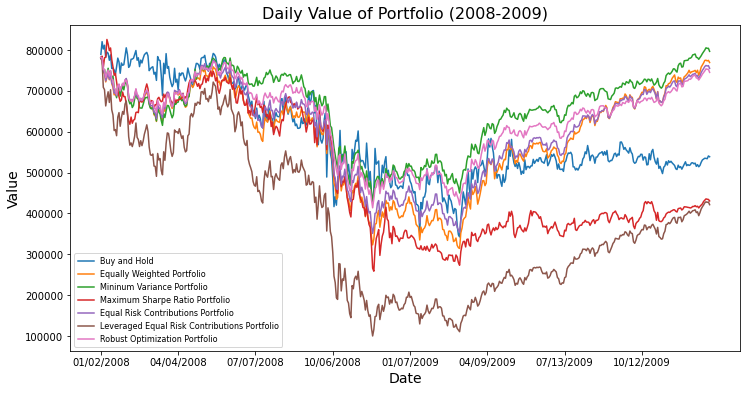

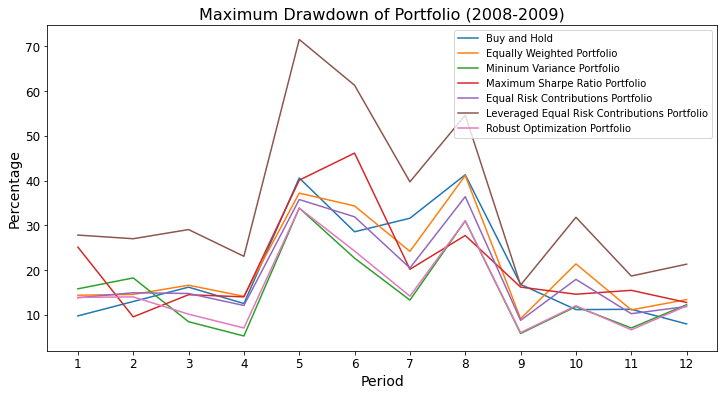

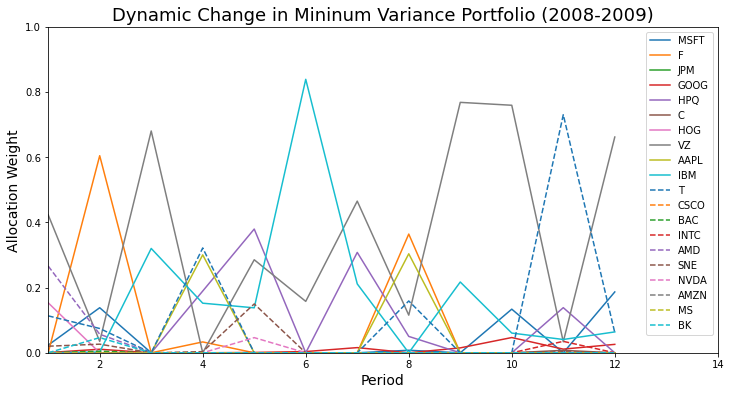

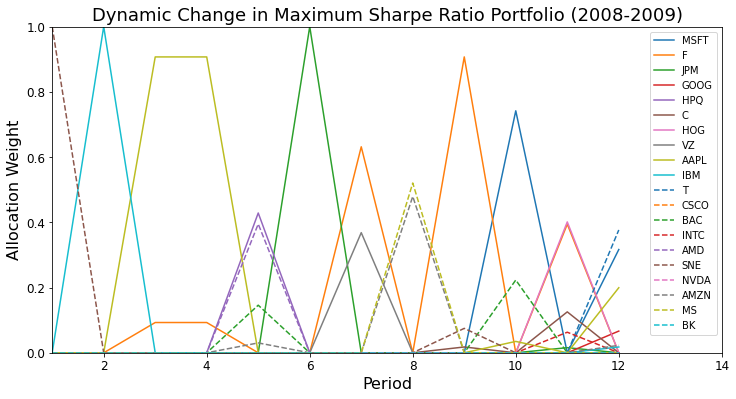

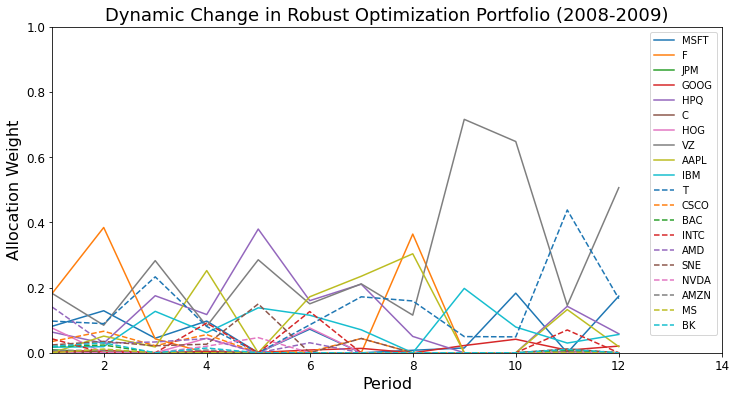

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import matplotlib.pyplot as plt
import ipopt

def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    init_port_value = np.dot(x_init, cur_prices) + cash_init
    w_optimal = x_optimal * cur_prices / init_port_value 
    return x_optimal, cash_optimal, w_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):   
    init_port_value = np.dot(x_init, cur_prices) + cash_init
    
    # each asset holds 1/20 of initial portfolio value
    asset_value = np.ones(20) * 1/20 * init_port_value

    # new positions
    # rounding strategy: round down number of shares to integer
    x_optimal = asset_value // cur_prices

    transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
    cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost
    
    # if cash account is negative, cash_req stores is the amount of investment to decrease
    # otherwise, it is useless
    cash_req = cash_optimal 
    while cash_optimal < 0:    
        invest_value = init_port_value + cash_req
        asset_value = np.ones(20) * 1/20 * invest_value    
        x_optimal = asset_value // cur_prices
        transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
        cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost
        cash_req = cash_req - 100
    w_optimal = np.ones(20) * 1/20
    return x_optimal, cash_optimal, w_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # formulate minimum variance optimization
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)   
    c = [0] * N
    ub = np.ones(N) * cplex.infinity
    cols = [[[0],[1]]] * N  
    cpx.linear_constraints.add(rhs=[1], senses='E')  
    cpx.variables.add(obj=c, ub=ub, columns = cols, names=["x{0}".format(i+1) for i in range(1,N+1)])
    qmat = [[[], []] for _ in range(N)]
    for k in range(N):
        qmat[k][0] = [i for i in range(N)]
        qmat[k][1] = (2*Q).tolist()[k]
    cpx.objective.set_quadratic(qmat)

    # set CPLEX parameters 
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)

    # optimize the problem
    cpx.set_log_stream(None)
    cpx.set_results_stream(None)
    cpx.solve()

    w_optimal = cpx.solution.get_values()
    init_port_value = np.dot(x_init, cur_prices) + cash_init
    x_optimal = init_port_value * np.array(w_optimal) // cur_prices 
    transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
    
    cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost
    
    # if cash is negative, rebalance is required 
    cash_req = cash_optimal
    
    while cash_optimal < 0:    
        
        # decrease spent value
        invest_value = init_port_value + cash_req
        x_optimal = invest_value * np.array(w_optimal) // cur_prices
        transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
        cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost
        cash_req = cash_req - 100
    return x_optimal, cash_optimal, w_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    daily_rf = r_rf / 252
    # set objective to minimize 
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0] * (N+1)
    
    # define linear constraint
    diff = mu.T - daily_rf
    cols = []
    for i in range(N): 
        cols.append([[0,1],[diff[i], 1]])
    cols.append([[0,1],[0,-1]])
    
    # define upper bounds of weights
    ub = np.ones(N+1) * cplex.infinity
    
    # add constraints
    cpx.linear_constraints.add(rhs=[1,0], senses='EE') 
    
    # add bounds, constraints to CPLEX model
    cpx.variables.add(obj=c, ub=ub, columns = cols, names=["x{0}".format(i+1) for i in range(1,N+2)])

    # add quadratic part of objective function
    qmat = [[[], []] for _ in range(N+1)]
    for k in range(N):
        qmat[k][0] = [i for i in range(N+1)]
        list = (2*Q).tolist()[k]
        list.append(0)
        qmat[k][1] = list
    qmat[k+1][0] = [i for i in range(N+1)]
    qmat[k+1][1] = np.zeros(N+1).tolist()
    cpx.objective.set_quadratic(qmat)
    
    # set CPLEX parameters 
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    # optimize the problem
    cpx.set_log_stream(None)
    cpx.set_results_stream(None)
    cpx.solve()
    
    init_port_value = np.dot(x_init, cur_prices) + cash_init
    
    if cpx.solution.get_status_string() == 'infeasible': 
        x_optimal = x_init
        w_optimal = x_init * cur_prices / init_port_value 
    else: 
        w_optimal = np.array(cpx.solution.get_values(0,N-1)) / cpx.solution.get_values(N)
        x_optimal = init_port_value * w_optimal // cur_prices 
    
    # transaction cost
    transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
    
    cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost
    
    # if cash is negative, rebalance is required 
    cash_req = cash_optimal
    
    while cash_optimal < 0:    
        
        # decrease spent value
        invest_value = init_port_value + cash_req
        
        # update optimal shares 
        x_optimal = invest_value * w_optimal // cur_prices
        transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
        cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost
        cash_req = cash_req - 100    
    
  
    return x_optimal, cash_optimal, w_optimal

def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(N):
                for j in range(i,N):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(N)
                  
            # Insert your gradient computations here
            # You can use finite differences to check the gradient
            y = x * np.dot(Q, x)
            for i in range(N): 
                for j in range(i,N):
                    diff1 = np.dot(Q[i,:], x) + np.dot(Q[i][i],x[i])
                    diff2 = np.dot(Q[i][j], x[i])
                    del_g = (y[i]-y[j])*(diff1-diff2)
                    grad[i] = grad[i] + del_g
                grad[i] = 2*2*grad[i]
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * N
    
        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * N])
    
    # Define initial portfolio ('1/N portfolio')
    w0 = [1/N] * N
    lb = [0] * N
    ub = [1] * N
    cl = [1]
    cu = [1]
    
    # Define IPOPT problem 
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(),lb=lb,ub=ub,cl=cl,cu=cu)
    
    # Set the IPOPT options
    nlp.addOption('jac_c_constant','yes')
    nlp.addOption('hessian_approximation','limited-memory')
    nlp.addOption('mu_strategy','adaptive')
    nlp.addOption('tol',1e-10)
    
    # Solve the problem and scale to weight sum = 1
    w_erc, info = nlp.solve(w0)
    w_erc = w_erc*(1/w_erc.sum())
    
    init_port_value = np.dot(x_init, cur_prices) + cash_init
    x_optimal = init_port_value * w_erc // cur_prices
    
    # transaction cost
    transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
    cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost
    
    # if cash is negative, rebalance is required 
    cash_req = cash_optimal
    
    while cash_optimal < 0:    
        
        # decrease spent value
        invest_value = init_port_value + cash_req
        
        # update optimal shares 
        x_optimal = invest_value * w_erc // cur_prices
        transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
        cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost
        cash_req = cash_req - 100 
    
    return x_optimal, cash_optimal, w_erc

def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(N):
                for j in range(i,N):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(N)
                  
            # Insert your gradient computations here
            # You can use finite differences to check the gradient
            y = x * np.dot(Q, x)
            for i in range(N): 
                for j in range(i,N):
                    diff1 = np.dot(Q[i,:], x) + np.dot(Q[i][i],x[i])
                    diff2 = np.dot(Q[i][j], x[i])
                    del_g = (y[i]-y[j])*(diff1-diff2)
                    grad[i] = grad[i] + del_g
                grad[i] = 2*2*grad[i]
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * N
    
        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * N])
        
    # Define initial portfolio ('1/N portfolio')
    w0 = [1/N] * N
    lb = [0] * N
    ub = [1] * N
    cl = [1]
    cu = [1]
    
    # Define IPOPT problem 
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(),lb=lb,ub=ub,cl=cl,cu=cu)
    
    # Set the IPOPT options
    nlp.addOption('jac_c_constant','yes')
    nlp.addOption('hessian_approximation','limited-memory')
    nlp.addOption('mu_strategy','adaptive')
    nlp.addOption('tol',1e-10)
    
    # Solve the problem and scale to weight sum = 1
    w_lerc, info = nlp.solve(w0)
    w_lerc = w_lerc*(1/w_lerc.sum())
        
    # 200% long position in every period   
    if period == 1: 
        init_port_value = np.dot(x_init, cur_prices) + cash_init
        last_borrow_value = 0 # from last period 
        left_port_value = init_port_value 
        init_port_value = 2 * init_port_value
        x_optimal = init_port_value * w_lerc // cur_prices
        transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
    
    else: 
        init_port_value = np.dot(x_init, cur_prices) + cash_init
        if cur_month == 1: 
            last_ind_start = min([i for i, val in enumerate((dates_array[:,0] == 2008) & (dates_array[:,1] == 11)) if val])
        else: 
            last_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == (cur_month-2))) if val])
        last_borrow_value = portf_value[strategy][last_ind_start][0] # from last period 
        interest = last_borrow_value * r_rf/6
        selling_trans = last_borrow_value * 0.005
        # return money borrowed from last period 
        left_port_value = init_port_value - last_borrow_value - interest - selling_trans
        new_borrow_value = left_port_value
        init_port_value = left_port_value + new_borrow_value
        x_optimal = init_port_value * w_lerc // cur_prices
        # transaction cost
        transaction_cost = abs(np.dot(x_optimal, cur_prices) - left_port_value) * 0.005
    
    cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost 
    
    # if cash is negative, rebalance is required 
    cash_req = cash_optimal
    
    while cash_optimal < 0:    
        
        # decrease spent value
        invest_value = init_port_value + cash_req
        
        # update optimal shares 
        x_optimal = invest_value * w_lerc // cur_prices
        if period == 1: 
            transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
        else: 
            transaction_cost = abs(np.dot(x_optimal, cur_prices) - left_port_value) * 0.005
        cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost 
        cash_req = cash_req - 100 
        
    return x_optimal, cash_optimal, w_lerc

def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    
    # Define initial portfolio weight ('1/N portfolio')
    w0 = [1/N] * N
    #w0 = weight[2][period-1]
    w_minVar = weight[2][period-1]
    ret_minVar = np.dot(mu, w_minVar)
    Portf_Retn = ret_minVar
    
    # Required portfolio robustness
    var_matr = np.diag(np.diag(Q))
    # Target portfolio return estimation error is return estimation error of 1/n portfolio
    rob_init = np.dot(w0, np.dot(var_matr, w0)) # return estimation error of initial portfolio
    rob_bnd  = rob_init # target return estimation error
    
    # Target portfolio return is return of minimum variance portfolio
    Portf_Retn = ret_minVar
    
    # Initiate CPLEX solver
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    # Define constraints
    c  = [0.0] * N
    lb = [0.0] * N
    ub = [1.0] * N
    A = []
    for k in range(N):
        A.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,N+1)]
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    # Quadratic constraint
    qmat = [[list(range(N)), list(2*Q[k,:])] for k in range(N)]
    cpx.objective.set_quadratic(qmat)
    
    # Quadratic robustness constraint
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(N), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_log_stream(None)
    cpx.set_results_stream(None)
    cpx.solve()
    
    w_rMV = cpx.solution.get_values()
    w_rMV = np.array(w_rMV)
    w_rMV = w_rMV / np.sum(w_rMV)
    
    init_port_value = np.dot(x_init, cur_prices) + cash_init
    x_optimal = init_port_value * w_rMV // cur_prices
    
    # transaction cost
    transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
    cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost
    
    # if cash is negative, rebalance is required 
    cash_req = cash_optimal
    
    while cash_optimal < 0:    
        
        # decrease spent value
        invest_value = init_port_value + cash_req
        
        # update optimal shares 
        x_optimal = invest_value * w_rMV // cur_prices
        transaction_cost = np.dot(abs(x_optimal-x_init), cur_prices)* 0.005
        cash_optimal = init_port_value - np.dot(x_optimal, cur_prices) - transaction_cost
        cash_req = cash_req - 100 

    return x_optimal, cash_optimal, w_rMV

# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]
    
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf= 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 6  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
first_trade_day = []

for period in range(1, N_periods+1):   
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  =  8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Append first trade day
    first_trade_day.append(day_ind_start)
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy in range(N_strat):

        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        
        if strategy == 5: 
            if period == 1: 
                portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value  
            else: 
                portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
                portf_value[strategy][day_ind_start:day_ind_end+1] = portf_value[strategy][day_ind_start:day_ind_end+1] - portf_value[strategy][day_ind_start]/2
        else: 
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
            
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)

# Plot results
fig = plt.figure(figsize=(12,6))
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.plot(dates, portf_value[0], label='Buy and Hold')
plt.plot(dates, portf_value[1], label='Equally Weighted Portfolio')
plt.plot(dates, portf_value[2], label='Mininum Variance Portfolio')
plt.plot(dates, portf_value[3], label='Maximum Sharpe Ratio Portfolio')
plt.plot(dates, portf_value[4], label='Equal Risk Contributions Portfolio')
plt.plot(dates, portf_value[5], label='Leveraged Equal Risk Contributions Portfolio')
plt.plot(dates, portf_value[6], label='Robust Optimization Portfolio')
plt.legend(fontsize=8)
plt.title('Daily Value of Portfolio (2008-2009)')
plt.xticks(df['Date'][40:])
plt.locator_params(axis = 'x', nbins = 8)
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

fig = plt.figure(figsize=(12,6))
for strategy in range(N_strat):
    mdd_list = []
    for period in range(1, N_periods+1):
        if dates_array[0, 0] == 8:
            cur_year  = 8 + math.floor(period/7)
        else:
            cur_year  = 2008 + math.floor(period/7)

        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        mdd = abs(portf_value[strategy][day_ind_start:day_ind_end+1].max()-portf_value[strategy][day_ind_start:day_ind_end+1].min())/portf_value[strategy][day_ind_start:day_ind_end+1].max()*100
        mdd_list.append(mdd)
    plt.plot(range(1,13),mdd_list,label=strategy_names[strategy])
plt.xlabel('Period')
plt.xticks(np.arange(1,13),fontsize=12)
plt.ylabel('Percentage')
plt.yticks(fontsize=12)
plt.title('Maximum Drawdown of Portfolio (2008-2009)')
plt.legend(fontsize=10)
plt.show()

# Plot change in portfolio allocations of minimum variance portfolio
position_weights = []
for period in range(1, N_periods+1): 
    position_weight = x[2,period-1]/np.sum(x[2,period-1])
    position_weights.append(position_weight)
position_weights = pd.DataFrame(position_weights, columns = df.columns[1:], index=range(1,13)).T.values

fig = plt.figure(figsize=(12,6))
stocks = ['MSFT','F','JPM','GOOG','HPQ','C','HOG','VZ','AAPL','IBM','T','CSCO','BAC','INTC',\
'AMD','SNE','NVDA','AMZN','MS','BK']

for i in range(0,10): 
    plt.plot(range(1,13), position_weights[i], label=stocks[i])
for i in range(10,20): 
    plt.plot(range(1,13), position_weights[i], '--', label=stocks[i])
    
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.xlim(1,14)
plt.ylim(0,1)
plt.title('Dynamic Change in Mininum Variance Portfolio (2008-2009)')
plt.ylabel('Allocation Weight')
plt.xlabel('Period')
plt.legend(fontsize=10, loc='upper right')
plt.show()

# Plot change in portfolio allocations of maximum sharpe ratio
position_weights = []
for period in range(1, N_periods+1): 
    position_weight = x[3,period-1]/np.sum(x[3,period-1])
    position_weights.append(position_weight)
position_weights = pd.DataFrame(position_weights, columns = df.columns[1:], index=range(1,13)).T.values

fig = plt.figure(figsize=(12,6))
stocks = ['MSFT','F','JPM','GOOG','HPQ','C','HOG','VZ','AAPL','IBM','T','CSCO','BAC','INTC',\
'AMD','SNE','NVDA','AMZN','MS','BK']

for i in range(0,10): 
    plt.plot(range(1,13), position_weights[i], label=stocks[i])
for i in range(10,20): 
    plt.plot(range(1,13), position_weights[i], '--', label=stocks[i])
    
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.xlim(1,14)
plt.ylim(0,1)
plt.title('Dynamic Change in Maximum Sharpe Ratio Portfolio (2008-2009)')
plt.ylabel('Allocation Weight')
plt.xlabel('Period')
plt.legend(fontsize=10, loc='upper right')
plt.show()

# Plot change in portfolio allocations of robust optimization portfolio
position_weights = []
for period in range(1, N_periods+1): 
    position_weight = x[6,period-1]/np.sum(x[6,period-1])
    position_weights.append(position_weight)
position_weights = pd.DataFrame(position_weights, columns = df.columns[1:], index=range(1,13)).T.values

fig = plt.figure(figsize=(12,6))
stocks = ['MSFT','F','JPM','GOOG','HPQ','C','HOG','VZ','AAPL','IBM','T','CSCO','BAC','INTC',\
'AMD','SNE','NVDA','AMZN','MS','BK']

for i in range(0,10): 
    plt.plot(range(1,13), position_weights[i], label=stocks[i])
for i in range(10,20): 
    plt.plot(range(1,13), position_weights[i], '--', label=stocks[i])
    
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.xlim(1,14)
plt.ylim(0,1)
plt.title('Dynamic Change in Robust Optimization Portfolio (2008-2009)')
plt.ylabel('Allocation Weight')
plt.xlabel('Period')
plt.legend(fontsize=10, loc='upper right')
plt.show()